In [493]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'



In [494]:
# Create a Spark session
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, lag, avg
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName("StockAnalysis").enableHiveSupport().getOrCreate()# Create a Spark session

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [495]:
# Load the CSV file into a PySpark DataFrame
filepath=("file:///home/talentum/test-jupyter/project/fb_price.csv")
df = spark.read.format("csv").load(filepath, header=True, inferSchema=True)

# Code-1 (calculating_stock_returns)

In [496]:
# Select relevant columns
df = df.withColumnRenamed("Date", "date").withColumnRenamed("Adj Close", "price_t")  
df.show(10)

+-------------------+---------+---------+---------+---------+---------+---------+
|               date|     Open|     High|      Low|    Close|  price_t|   Volume|
+-------------------+---------+---------+---------+---------+---------+---------+
|2012-05-18 00:00:00|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|
|2012-05-21 00:00:00|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|
|2012-05-22 00:00:00|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|
|2012-05-23 00:00:00|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000|
|2012-05-24 00:00:00|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|
|2012-05-25 00:00:00|32.900002|32.950001|31.110001|    31.91|    31.91| 37149800|
|2012-05-29 00:00:00|    31.48|31.690001|    28.65|    28.84|    28.84| 78063400|
|2012-05-30 00:00:00|28.700001|29.549999|27.860001|28.190001|28.190001| 57267900|
|2012-05-31 00:00:00|28.549999|    29.67|    26.83|     29.6|     29.6|111639200|
|2012-06-01 00:0

In [497]:
# Calculate returns
df = df.withColumn("returns", (col("price_t") / lag(col("price_t"), 1).over(Window.orderBy("date"))) - 1)



In [498]:
# Convert DataFrame to Pandas for plotting
pandas_df = df.toPandas() 

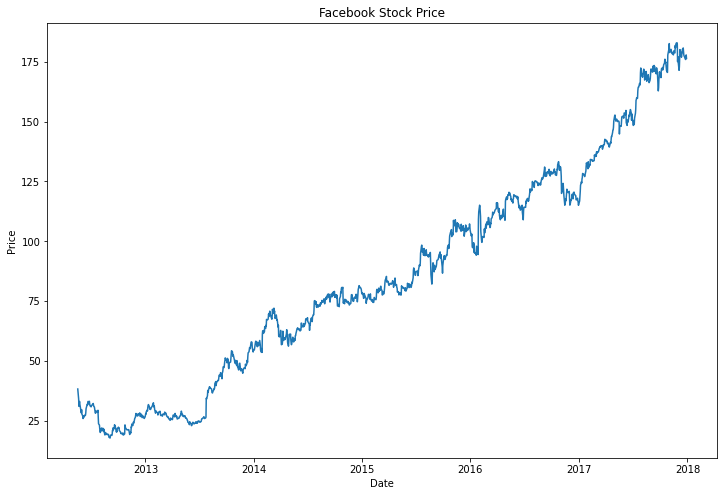

In [499]:
# Needs to be run in a Spark notebook / Databricks environment  
# Display the DataFrame without conversion to Pandas  
# Note: This requires a Spark environment that supports display()  
# display(df.select("date", "price_t").limit(100)) 

# Plot Facebook's Price data  
plt.figure(figsize=(12, 8))  
plt.plot(pandas_df["date"], pandas_df["price_t"])  
plt.title("Facebook Stock Price")  
plt.xlabel("Date")  
plt.ylabel("Price")  
plt.show()  

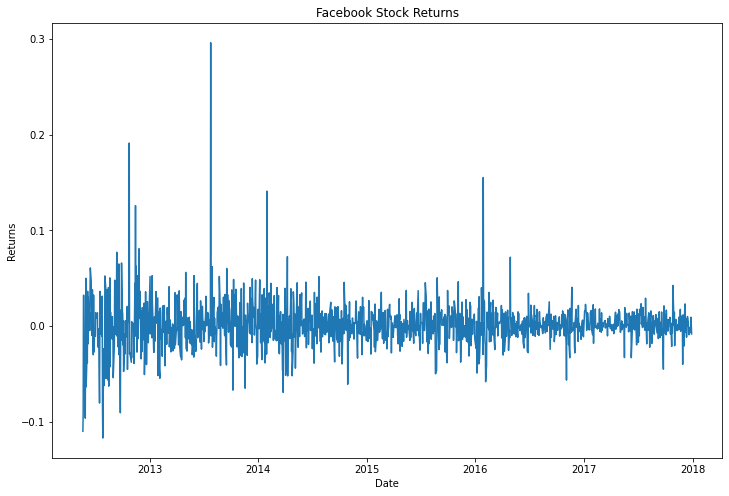

In [500]:
# Plot Facebook's Returns data  
plt.figure(figsize=(12, 8))  
plt.plot(pandas_df["date"], pandas_df["returns"])  
plt.title("Facebook Stock Returns")  
plt.xlabel("Date")  
plt.ylabel("Returns")  
plt.show()

# Code-2 (expected_return_function)

In [501]:
# Function to calculate daily expected return
def getExpectedReturn(df, price_col_name: str) -> float:
    returns = df.withColumn("returns", (F.col(price_col_name) / F.lag(price_col_name).over(Window.orderBy("date"))) - 1)
    expected_return = returns.agg(F.mean("returns")).first()[0]
    return expected_return

In [502]:
# Function to calculate annualized expected return
def getExpectedReturnAnnualised(df, price_col_name: str, annualised: bool = True, annualise_method: str = 'sophisticated') -> float:
    returns = df.withColumn("returns", (F.col(price_col_name) / F.lag(price_col_name).over(Window.orderBy("date"))) - 1)
    expected_return_daily = returns.agg(F.mean("returns")).first()[0]
    if annualised:
        if annualise_method == 'sophisticated':
            expected_return_annual = ((1 + expected_return_daily) ** 250) - 1
        elif annualise_method == 'crude':
            expected_return_annual = expected_return_daily * 250
        return expected_return_annual
    else:
        return expected_return_daily

In [503]:
# Calculate expected returns
annualised_sophisticated = getExpectedReturnAnnualised(df, 'price_t')
print(f"Annualised Expected Return (sophisticated method): {annualised_sophisticated}")

Annualised Expected Return (sophisticated method): 0.40093243279785296


In [504]:
daily_expected_return = getExpectedReturn(df, 'price_t')
print(f"Daily Expected Return: {daily_expected_return}")

Daily Expected Return: 0.001349461858750009


In [505]:
annualised_crude = getExpectedReturnAnnualised(df, 'price_t', annualise_method='crude')
print(f"Annualised Expected Return (crude method): {annualised_crude}")

Annualised Expected Return (crude method): 0.3373654646875022


# Code-3 (expected_return_mean)

In [506]:
# Select relevant columns
df = df.select("date", "price_t")
# Calculate returns
df = df.withColumn("returns", (col("price_t") / lag(col("price_t"), 1).over(Window.orderBy("date"))) - 1)

In [507]:
df.show(10)

+-------------------+---------+--------------------+
|               date|  price_t|             returns|
+-------------------+---------+--------------------+
|2012-05-18 00:00:00|    38.23|                null|
|2012-05-21 00:00:00|34.029999|-0.10986139157729535|
|2012-05-22 00:00:00|     31.0|-0.08903905639256693|
|2012-05-23 00:00:00|     32.0|0.032258064516129004|
|2012-05-24 00:00:00|33.029999| 0.03218746874999989|
|2012-05-25 00:00:00|    31.91|-0.03390853871960442|
|2012-05-29 00:00:00|    28.84|-0.09620808523973678|
|2012-05-30 00:00:00|28.190001|-0.02253810679611...|
|2012-05-31 00:00:00|     29.6|0.050017699538215776|
|2012-06-01 00:00:00|27.719999| -0.0635135472972973|
+-------------------+---------+--------------------+
only showing top 10 rows



In [508]:
# Calculate the mean-based Expected Return
expected_return_fb = df.select("returns").agg({"returns": "avg"}).collect()[0][0]

# Add expected return columns
df = df.withColumn("expected_return_fb", col("returns") * 0 + expected_return_fb)

In [509]:
# Estimate 30-day and 7-day moving average expected returns
df = df.withColumn("expected_return_ma_30d", avg(col("returns")).over(Window.orderBy("date").rowsBetween(-29, 0)))
df = df.withColumn("expected_return_ma_7d", avg(col("returns")).over(Window.orderBy("date").rowsBetween(-6, 0)))

In [510]:
df.show(10)

+-------------------+---------+--------------------+--------------------+----------------------+---------------------+
|               date|  price_t|             returns|  expected_return_fb|expected_return_ma_30d|expected_return_ma_7d|
+-------------------+---------+--------------------+--------------------+----------------------+---------------------+
|2012-05-18 00:00:00|    38.23|                null|                null|                  null|                 null|
|2012-05-21 00:00:00|34.029999|-0.10986139157729535|0.001349461858750009|  -0.10986139157729535| -0.10986139157729535|
|2012-05-22 00:00:00|     31.0|-0.08903905639256693|0.001349461858750009|  -0.09945022398493114| -0.09945022398493114|
|2012-05-23 00:00:00|     32.0|0.032258064516129004|0.001349461858750009|  -0.05554746115124...| -0.05554746115124...|
|2012-05-24 00:00:00|33.029999| 0.03218746874999989|0.001349461858750009|  -0.03361372867593...| -0.03361372867593...|
|2012-05-25 00:00:00|    31.91|-0.03390853871960

In [511]:
# Convert DataFrame to Pandas for plotting
pandas_df = df.toPandas()
pandas_df.set_index("date", inplace=True)

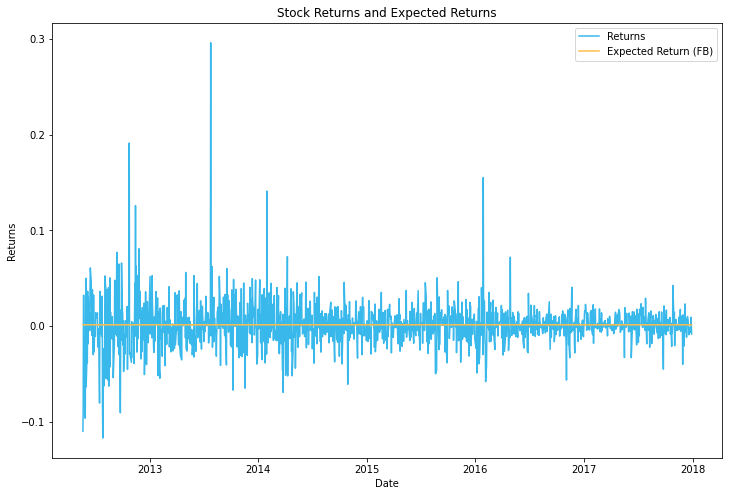

In [512]:
# Plot the data using Matplotlib
plt.figure(figsize=(12, 8))
plt.plot(pandas_df.index, pandas_df["returns"], label="Returns", color="#39b8eb")
plt.plot(pandas_df.index, pandas_df["expected_return_fb"], label="Expected Return (FB)", color="#ffbd4a")
plt.title("Stock Returns and Expected Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

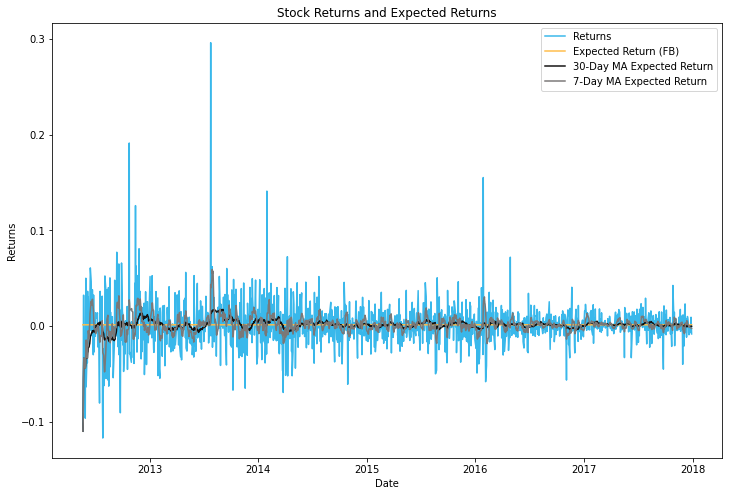

In [513]:
# Plot the data using Matplotlib (optional)
plt.figure(figsize=(12, 8))
plt.plot(pandas_df.index, pandas_df["returns"], label="Returns", color="#39b8eb")
plt.plot(pandas_df.index, pandas_df["expected_return_fb"], label="Expected Return (FB)", color="#ffbd4a")
plt.plot(pandas_df.index, pandas_df["expected_return_ma_30d"], label="30-Day MA Expected Return", color="#121111")
plt.plot(pandas_df.index, pandas_df["expected_return_ma_7d"], label="7-Day MA Expected Return", color="#7a7878")
plt.title("Stock Returns and Expected Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

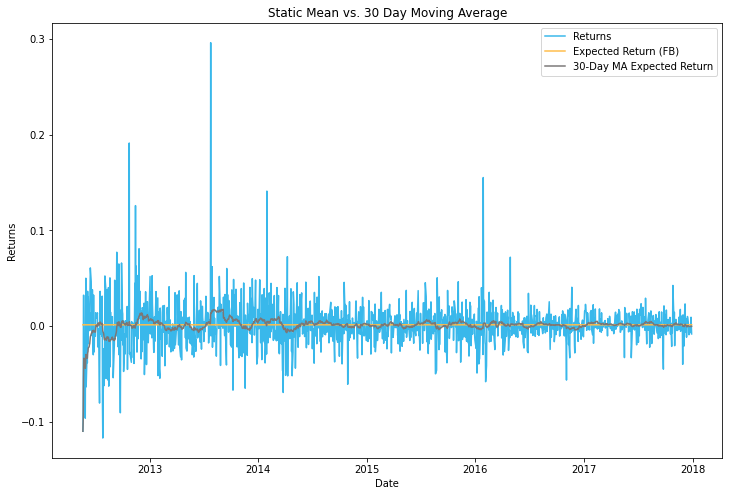

In [514]:
# Plot the data using Matplotlib (optional)
plt.figure(figsize=(12, 8))
plt.plot(pandas_df.index, pandas_df["returns"], label="Returns", color="#39b8eb")
plt.plot(pandas_df.index, pandas_df["expected_return_fb"], label="Expected Return (FB)", color="#ffbd4a")
plt.plot(pandas_df.index, pandas_df["expected_return_ma_30d"], label="30-Day MA Expected Return", color="#7a7878")
plt.title("Static Mean vs. 30 Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

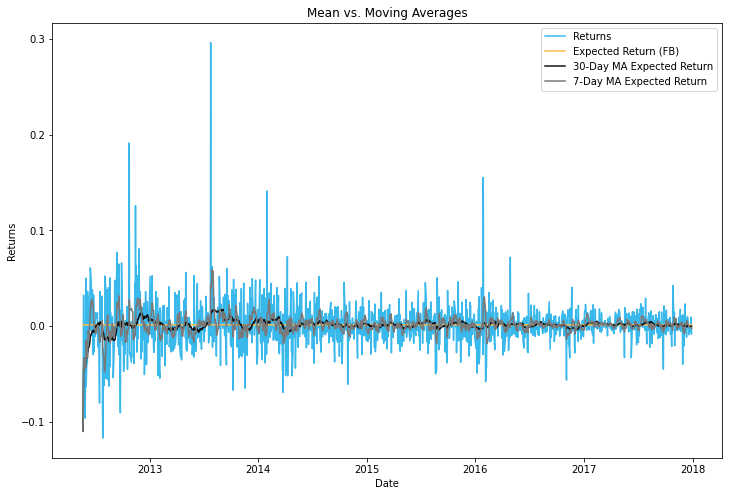

In [515]:
# Plot the data using Matplotlib (optional)
plt.figure(figsize=(12, 8))
plt.plot(pandas_df.index, pandas_df["returns"], label="Returns", color="#39b8eb")
plt.plot(pandas_df.index, pandas_df["expected_return_fb"], label="Expected Return (FB)", color="#ffbd4a")
plt.plot(pandas_df.index, pandas_df["expected_return_ma_30d"], label="30-Day MA Expected Return", color="#121111")
plt.plot(pandas_df.index, pandas_df["expected_return_ma_7d"], label="7-Day MA Expected Return", color="#7a7878")
plt.title("Mean vs. Moving Averages")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

# Code-4 (expected_return_ap_models1_applied)

In [516]:
# Load the CSV file into a PySpark DataFrame
filepath=("file:///home/talentum/test-jupyter/project/sp500_price.csv")
sp500 = spark.read.format("csv").load(filepath, header=True, inferSchema=True)


In [517]:
sp500.show(10)

+------------------+-------+
|              Date|  sp500|
+------------------+-------+
|  01/03/2012 16:00|1277.06|
|  01/04/2012 16:00| 1277.3|
|  01/05/2012 16:00|1281.06|
|  01/06/2012 16:00|1277.81|
|  01/09/2012 16:00| 1280.7|
|  01/10/2012 16:00|1292.08|
|  01/11/2012 16:00|1292.48|
|  01/12/2012 16:00| 1295.5|
|1/13/2012 16:00:00|1289.09|
|1/17/2012 16:00:00|1293.67|
+------------------+-------+
only showing top 10 rows



In [518]:
# Calculate returns for SP500  
sp500 = sp500.withColumn("returns", (col("sp500") / lag(col("sp500"), 1).over(Window.orderBy("Date"))) - 1)

# Calculate the mean-based Expected Return (similar to Facebook)  
expected_return_sp500 = sp500.select(F.mean("returns")).first()[0]

In [519]:
# Define and register the UDF for CAPM expected return  
from pyspark.sql import functions as F  
from pyspark.sql.types import DoubleType  

def capm_expected_return(r_f, expected_return_market, beta_j):  
    return float(r_f + beta_j * (expected_return_market - r_f))

In [520]:
# Register the function as a UDF  
capm_expected_return_udf = F.udf(capm_expected_return, DoubleType())

In [521]:
sp500.printSchema()

root
 |-- Date: string (nullable = true)
 |-- sp500: double (nullable = true)
 |-- returns: double (nullable = true)



In [522]:
# Calculate the CAPM expected return for Alphabet Inc (GOOGL)
r_f = 0.0309  # 10-year yield on US Treasuries
beta_j = 1.1233  # Beta of Alphabet Inc (GOOGL)
#expected_return_market = sp500.select("expected_return_annual").collect()[0][0]
expected_return_market = expected_return_sp500

In [523]:
# Create a DataFrame with the input values
input_df = spark.createDataFrame([(r_f, expected_return_market, beta_j)],
                                 ["r_f", "expected_return_market", "beta_j"])

In [524]:
# After loading the SP500 and calculating expected returns, you can now apply the UDF  
result_df = input_df.withColumn("expected_return_capm",  
                                 capm_expected_return_udf(F.col("r_f"),  
                                                          F.col("expected_return_market"),  
                                                          F.col("beta_j")))

In [525]:
# Show the result
result_df.show()

+------+----------------------+------+--------------------+
|   r_f|expected_return_market|beta_j|expected_return_capm|
+------+----------------------+------+--------------------+
|0.0309|   0.03461221109434794|1.1233| 0.03506992672228104|
+------+----------------------+------+--------------------+



In [526]:
# Print the CAPM expected return
expected_return_capm = result_df.select("expected_return_capm").collect()[0][0]
print(f"CAPM Expected Return for Alphabet Inc (GOOGL): {expected_return_capm:.4f}")

CAPM Expected Return for Alphabet Inc (GOOGL): 0.0351
